In [47]:
import fbprophet
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

In [3]:
#load vulnerable areas data
gdb_file = 'Climate_Change_Vulnerability_NE/Climate_Change_Vulnerability_NE.gdb'

layers = fiona.listlayers(gdb_file)
for layer in layers:
    v_gdf = gpd.read_file(gdb_file,layer=layer)
    


DriverError: birds_2018_2019.csv: No such file or directory

In [46]:
#load birds data
birds = gpd.read_file('biodiversity_species_2011_2019.csv')

birds['Latitude (WGS84)'].replace('', np.nan, inplace=True)
birds['Longitude (WGS84)'].replace('', np.nan, inplace=True)

gbirds = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(x=birds['Longitude (WGS84)'].astype('float'),y=birds['Latitude (WGS84)'].astype('float')))


gbirds.crs = "EPSG:4326"
gbirds = gbirds.to_crs(epsg=3857)
gbirds.head()

,Occurrence ID,Family,Genus,Common name,Class,OSGR,Start date,area_represented,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Latitude (WGS84),Longitude (WGS84),geometry
0,1507997,Motacillidae,Anthus,Meadow Pipit,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
1,MMEEECJAEEEHGLKR,Rosaceae,Fragaria,Wild Strawberry,Magnoliopsida,SN71,,meadow,SN,SN71,,,51.819602,-3.814957,POINT (-424679.071 6767572.678)
2,1242731,Alaudidae,Alauda,Skylark,Aves,SK40N,,meadow,SK,SK40,SK40N,,52.658863,-1.336146,POINT (-148739.092 6920144.420)
3,1507896,Alaudidae,Alauda,Skylark,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
4,MMEEECJAEEE0SS3O,Motacillidae,Anthus,Meadow Pipit,Aves,SS79,,meadow,SS,SS79,,,51.63987,-3.80777,POINT (-423879.017 6735269.441)


In [48]:
# load zoomstack data

natp = gpd.read_file('OS_zoomstack_sample/OS_Open_Zoomstack greenspace.geojson')
natp = natp.to_crs(epsg=3857)


In [ ]:
#add month columns to birds data 

import pandas as pd

gbirds['dtm'] = pd.to_datetime(gbirds['Start date'])
gbirds['month_year'] = gbirds['dtm'].dt.to_period('M')
months = gbirds['month_year'].sort_values(ascending=True).drop_duplicates()
gbirds['dtm'].dt.to_period('M')


In [49]:
'''establish grid for dataset linking'''

# total area for the grid
import numpy as np 
import shapely

xmin, ymin, xmax, ymax = gbirds.total_bounds
# how many cells across and down

cell_size = 10000

# projection of the grid
crs = "EPSG:3857"
# create the cells in a loop

grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        half_step = cell_size/2
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0 + half_step, y0 + half_step, x1 + half_step, y1 + half_step)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

(-1031441.516938846, 255558.48306115405, 6311855.375421956, 8698855.375421956)

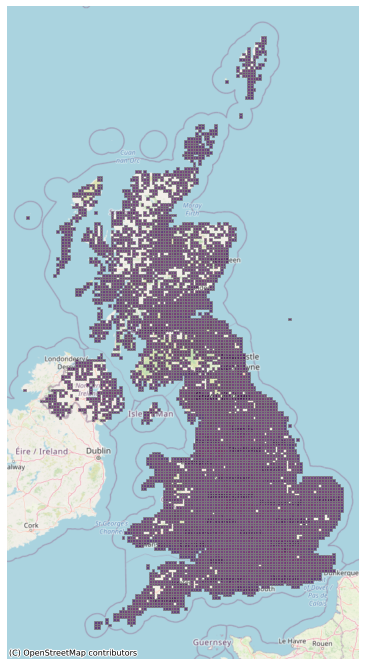

In [52]:
gridded_birds = gpd.sjoin(gbirds, cell, how='left', op='within')
gridded_birds['n_birds']=1

#Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = gridded_birds.dissolve(by="index_right", aggfunc="/number of different species/")
dissolve.head()

cell.loc[dissolve.index, 'n_birds'] = dissolve.n_birds.values
ax = cell.plot(column='n_birds', figsize=(16, 12), cmap='viridis', vmax=5000, edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)

ax.axis('off')



(-1020941.516938846, 255058.48306115405, 6311855.375421956, 8698855.375421956)

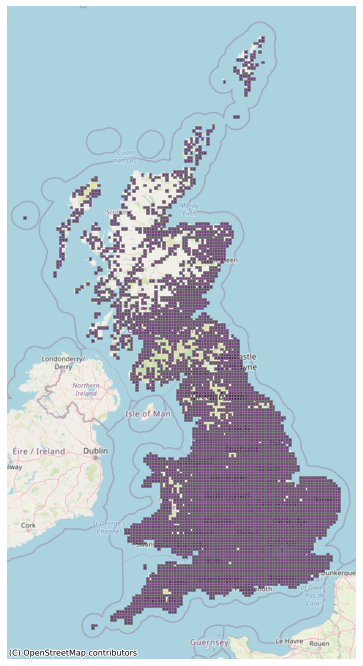

In [51]:
gridded_areas = gpd.sjoin(natp,cell, how='left', op='within')
gridded_areas.sort_values('index_right')


gridded_areas['n_areas'] = 1

dissolve_areas = gridded_areas.dissolve(by="index_right", aggfunc="count")

cell.loc[dissolve_areas.index, 'n_areas'] = dissolve_areas.n_areas.values

ax = cell.plot(column='n_areas', figsize=(16, 12), cmap='viridis', vmax=5000, edgecolor="grey",alpha=0.7)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.autoscale(False)

ax.axis('off')



In [55]:
cell.sort_values('n_birds',ascending=False)

,geometry,n_birds,n_areas
440,"POLYGON ((-972941.517 7290355.375, -972941.517...",1.0,NaN
43875,"POLYGON ((-212941.517 6920355.375, -212941.517...",1.0,56.0
43873,"POLYGON ((-212941.517 6900355.375, -212941.517...",1.0,73.0
43872,"POLYGON ((-212941.517 6890355.375, -212941.517...",1.0,182.0
43871,"POLYGON ((-212941.517 6880355.375, -212941.517...",1.0,207.0
...,...,...,...
829395,"POLYGON ((13517058.483 8560355.375, 13517058.4...",NaN,NaN
829396,"POLYGON ((13517058.483 8570355.375, 13517058.4...",NaN,NaN
829397,"POLYGON ((13517058.483 8580355.375, 13517058.4...",NaN,NaN
829398,"POLYGON ((13517058.483 8590355.375, 13517058.4...",NaN,NaN


In [ ]:
cell.sort_values('n_birds',ascending=False)

In [ ]:

birds['Longitude (WGS84)'].replace('', np.nan, inplace=True)